# Rinne Daily Dataset
## TE analysis

This script includes TE analysis for 3 cases:

1. Anomaly data series
2. Moving average at a ??? scale
3. Aggregated data.

There is also an optional Normalization procedure.

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy
from scipy.signal import lfilter, butter
import matplotlib.image as mpimg
from matplotlib import rcParams
import pylab
import importlib

# Local modules
import TEpython3
import TEpython4


# Develop anomaly time series


What Ben did: in Ruddell and Kumar, calculated anomaly based on time-of-day difference with a 5-day window. In Gerken and Ruddell et al. 2019, applied this to all time series except for precipitation. Looked at lags up to 18 hours and used 20 bins.

5 days doesn't seem like enough to me for the window. If there was one anomalous day within that window of 5, it could put the other days into a lower bin, even if those days were perfectly "normal." I will use 13 days instead, and a centered window.

In [2]:
# Read data table

table2 = pd.read_csv('Cleaned_subdaily.csv',header = 0,index_col = 'Datetime',parse_dates = True, infer_datetime_format = True,low_memory=False)

print(table2.shape)
table2.head(5)

(192816, 16)


,T_air,Rh,R_net,T_-5cm,T_-10cm,T_-20cm,T_-35cm,T_-50cm,WT,P,methane_flux,U,WD,Ustar,NEE,NEE_gapfilled
Datetime,,,,,,,,,,,,,,,,
2005-01-01 00:15:00,-1.6,86.9,-1.5,NaN,NaN,NaN,0.5,1.3,9.3,NaN,NaN,NaN,NaN,NaN,NaN,0.2044
2005-01-01 00:45:00,-1.5,86.4,-1.3,NaN,NaN,NaN,0.5,1.3,9.3,NaN,NaN,NaN,NaN,NaN,NaN,0.2044
2005-01-01 01:15:00,-1.4,85.6,-1.2,NaN,NaN,NaN,0.5,1.3,9.3,NaN,NaN,NaN,NaN,NaN,NaN,0.2044
2005-01-01 01:45:00,-1.2,84.6,-1.1,NaN,NaN,NaN,0.5,1.3,9.3,NaN,NaN,NaN,NaN,NaN,NaN,0.2044
2005-01-01 02:15:00,-0.9,81.2,-0.8,NaN,NaN,NaN,0.5,1.3,9.3,NaN,NaN,NaN,NaN,NaN,NaN,0.2044


In [3]:
def fastshift(arr, num, fill_value=np.nan): #Fast shift of elements within array (from https://stackoverflow.com/questions/30399534/shift-elements-in-a-numpy-array)
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [99]:
def nanPerAnomaly(data_col, win=13, min_valid_entries=5, ploton=0): #Derive a periodic anomaly based on a sliding window centered on the datapoint. Win should be an odd number. df = input data column.
#min_valid_entries is the minimum number of non-nan values in the window for the anomaly to be non-nan
    this_col = data_col.values #Get data column
    for i in range(int(np.floor(win/2))): #Build a matrix of days compared to each day
            #number of shifts should be i + 1
        if i == 0:
            window_mat = np.column_stack([fastshift(this_col, -48), this_col, fastshift(this_col, 48)])
        else:
            window_mat = np.column_stack([fastshift(this_col, -48*(i+1)), window_mat, fastshift(this_col, 48*(i+1))])
    mean_of_window = np.nanmean(window_mat, 1)
    valid_entries = np.sum(~np.isnan(window_mat),1) #non-nan entries
    mean_of_window[valid_entries<min_valid_entries]=np.nan
    anomaly = this_col-mean_of_window
    if ploton:
        plt.figure(figsize=[20,5])
        plt.plot(this_col)
        plt.plot(mean_of_window)
        plt.title(column)
        plt.figure(figsize=[20,5])
        plt.plot(anomaly, 'r-')
    
    return anomaly

In [101]:
##Apply the periodic anomaly removal

data = table2.copy(deep=True)
newData = data.apply(nanPerAnomaly, axis=0, win=5, min_valid_entries=2, ploton=0) #Apply the periodic anomaly and save it as a new data frame
#Delete the precipitation anomaly:
newData = newData.drop(['P'], axis=1);
#Add the non-anomaly precipitation back in:
newData['P']=copy.deepcopy(data.P)
newData.head(5)

C:\Users\Laurel Larsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


,T_air,Rh,R_net,T_-5cm,T_-10cm,T_-20cm,T_-35cm,T_-50cm,WT,methane_flux,U,WD,Ustar,NEE,NEE_gapfilled,P
Datetime,,,,,,,,,,,,,,,,
2005-01-01 00:15:00,-1.066667,-7.466667,-1.033333,NaN,NaN,NaN,0.0,0.0,0.166667,NaN,NaN,NaN,NaN,NaN,0.001167,NaN
2005-01-01 00:45:00,-0.966667,-8.700000,-0.866667,NaN,NaN,NaN,0.0,0.0,0.166667,NaN,NaN,NaN,NaN,NaN,0.016733,NaN
2005-01-01 01:15:00,-0.933333,-9.333333,-0.866667,NaN,NaN,NaN,0.0,0.0,0.166667,NaN,NaN,NaN,NaN,NaN,-0.006633,NaN
2005-01-01 01:45:00,-0.866667,-10.000000,-0.833333,NaN,NaN,NaN,0.0,0.0,0.166667,NaN,NaN,NaN,NaN,NaN,0.000433,NaN
2005-01-01 02:15:00,-0.700000,-12.500000,-0.633333,NaN,NaN,NaN,0.0,0.0,0.166667,NaN,NaN,NaN,NaN,NaN,-0.020267,NaN


Observation: Anomalies end up having pretty strong autocorrelation over a daily cycle and may not be telling us a story that is much different from the daily MA story. However, it will distinguish between whether daytime is warmer/colder or nighttime, so there is a little more information than the daily story. 

I do worry about pseudoreplication.

Try analysis with resampling. 

T-lag seems to be best, due to the autocorrelation in the anomaly. T-1 lag will be stricter.

In [7]:
#MOVE THIS

def nanMA(df, win, ploton): #df = input dataframe, win = window of rolling mean (centered on datapoint). Win should be an odd number
    valid_entries = ~np.isnan(df.copy(deep=True))
    not_valid = np.isnan(df.copy(deep=True))
    if ploton:
        plt.figure(figsize = [20,5])
        plt.plot(df.values)
    df = df.fillna(0) #Replace nans with zeros
    rolling_mean = df.rolling(window=win).sum()/valid_entries.rolling(window=win).sum() #This is currently backwards-looking
    rolling_mean[~np.isfinite(rolling_mean)] = np.nan #Replace divide-by-zeros with nan
    shifted = fastshift(rolling_mean, -int(np.floor(win/2)))#shift the window to centered on the datapoint
    result = df - shifted
    result[not_valid] = np.nan
    if ploton:
        plt.plot(shifted)
        plt.figure(figsize=[20,5])
        plt.plot(result, 'r-')
    return result, shifted

#### Test with methane flux
By running the box below with different window sizes, it appears that a monthly (31-day) window is reasonable

<IPython.core.display.Javascript object>


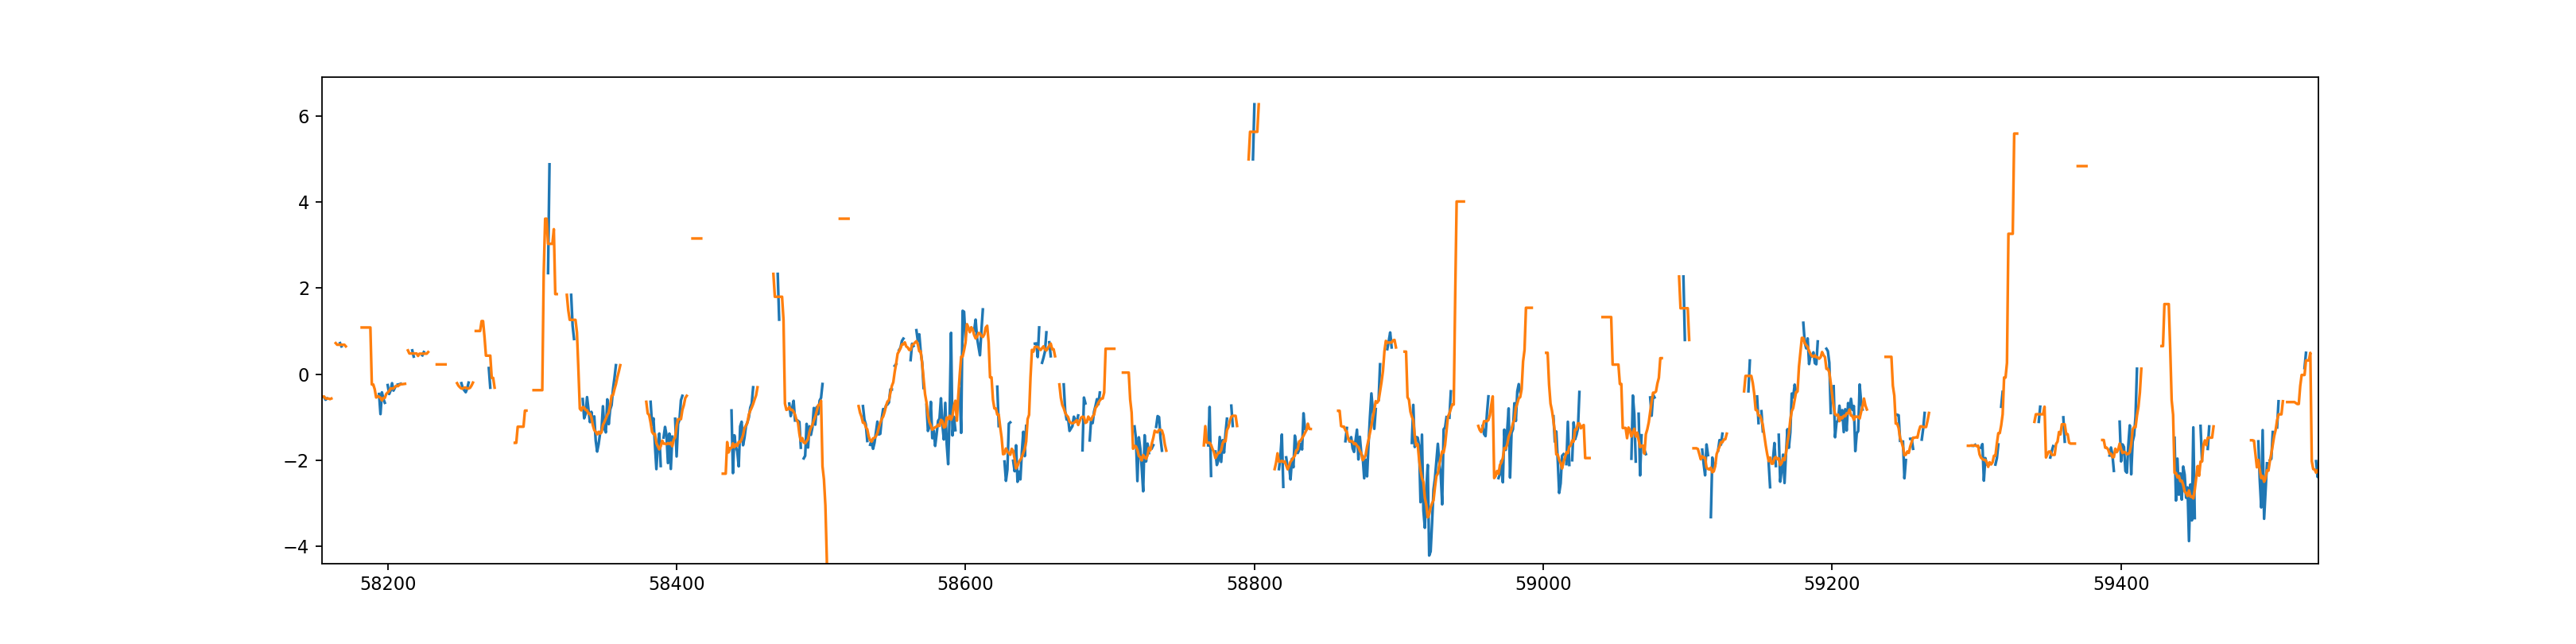

In [62]:
(result, shifted) = nanMA(table2['NEE'].copy(deep=True), 7, 0);

%matplotlib notebook
%matplotlib notebook
plt.figure(figsize = [20,5])
plt.plot(table2.NEE.values)
plt.plot(shifted)    

In [78]:
#MOVE THIS
# Apply the moving window function
win = 31 
data = table2.copy(deep=True)
newData = data.apply(nanMA, axis=0, win=win, ploton=0) # 
data.head(5)

,T_air,Rh,R_net,T_-5cm,T_-10cm,T_-20cm,T_-35cm,T_-50cm,WT,P,methane_flux,U,WD,Ustar,NEE,NEE_gapfilled
Datetime,,,,,,,,,,,,,,,,
2005-01-01 00:15:00,-1.6,86.9,-1.5,NaN,NaN,NaN,0.5,1.3,9.3,NaN,NaN,NaN,NaN,NaN,NaN,0.2044
2005-01-01 00:45:00,-1.5,86.4,-1.3,NaN,NaN,NaN,0.5,1.3,9.3,NaN,NaN,NaN,NaN,NaN,NaN,0.2044
2005-01-01 01:15:00,-1.4,85.6,-1.2,NaN,NaN,NaN,0.5,1.3,9.3,NaN,NaN,NaN,NaN,NaN,NaN,0.2044
2005-01-01 01:45:00,-1.2,84.6,-1.1,NaN,NaN,NaN,0.5,1.3,9.3,NaN,NaN,NaN,NaN,NaN,NaN,0.2044
2005-01-01 02:15:00,-0.9,81.2,-0.8,NaN,NaN,NaN,0.5,1.3,9.3,NaN,NaN,NaN,NaN,NaN,NaN,0.2044


### Evaluate autocorrelation functions.

In [103]:
def nanacf(X, maxlag=365): #Generates an autocorrelation function for X, ignoring missing variables. 
    nX = len(X)
    r = np.zeros(maxlag)
    sig_thr = np.zeros(maxlag)
    for ii in range(maxlag):
        if ii == 0:
            Y = X
            Z = X
        else:
            Y = X[:-ii].copy()
            Z = X[ii:].copy()
        Y[np.isnan(Z)]=np.nan
        Z[np.isnan(Y)]=np.nan
            
        r[ii] = np.corrcoef(Y[~np.isnan(Y)], Z[~np.isnan(Z)])[0,1]
        sig_thr[ii] = 3/np.sqrt(np.sum(~np.isnan(Y)))
 #   plt.plot(r)
 #   plt.xlabel('Lag')
 #   plt.ylabel('Autocorrelation')
    return r, sig_thr

<IPython.core.display.Javascript object>


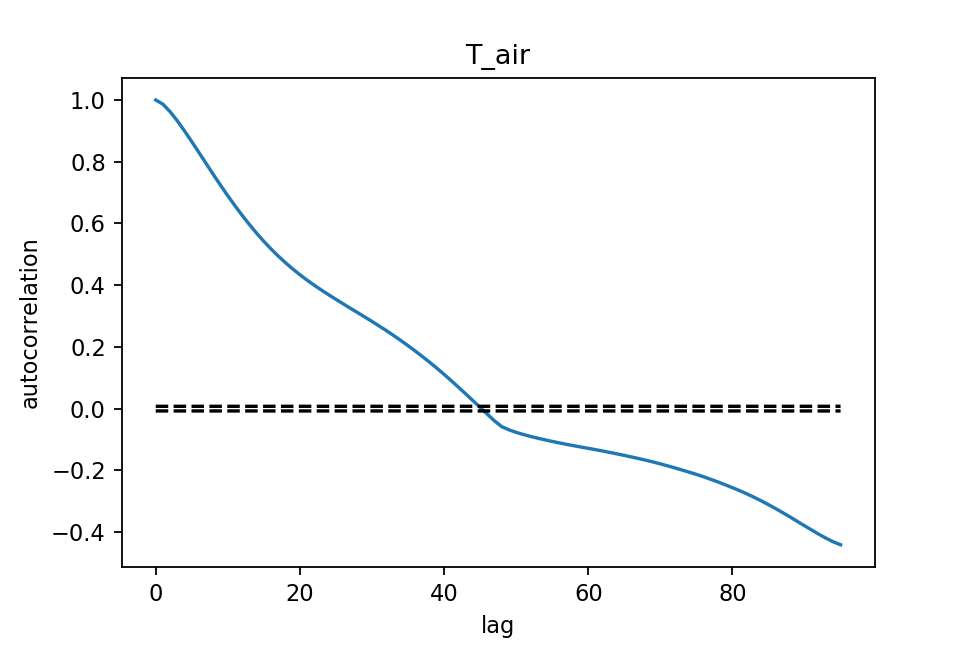

<IPython.core.display.Javascript object>


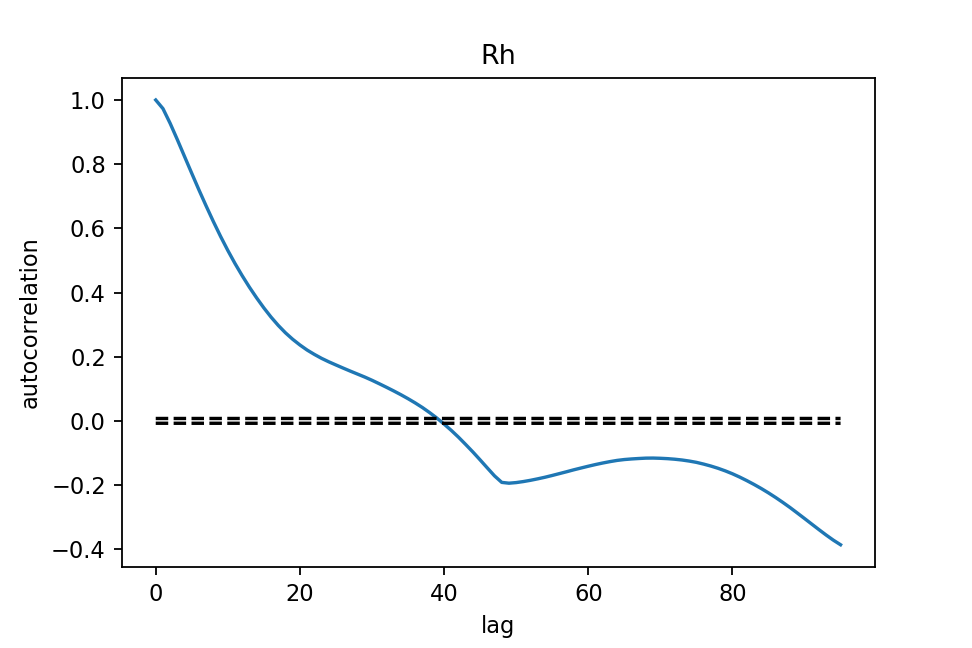

<IPython.core.display.Javascript object>


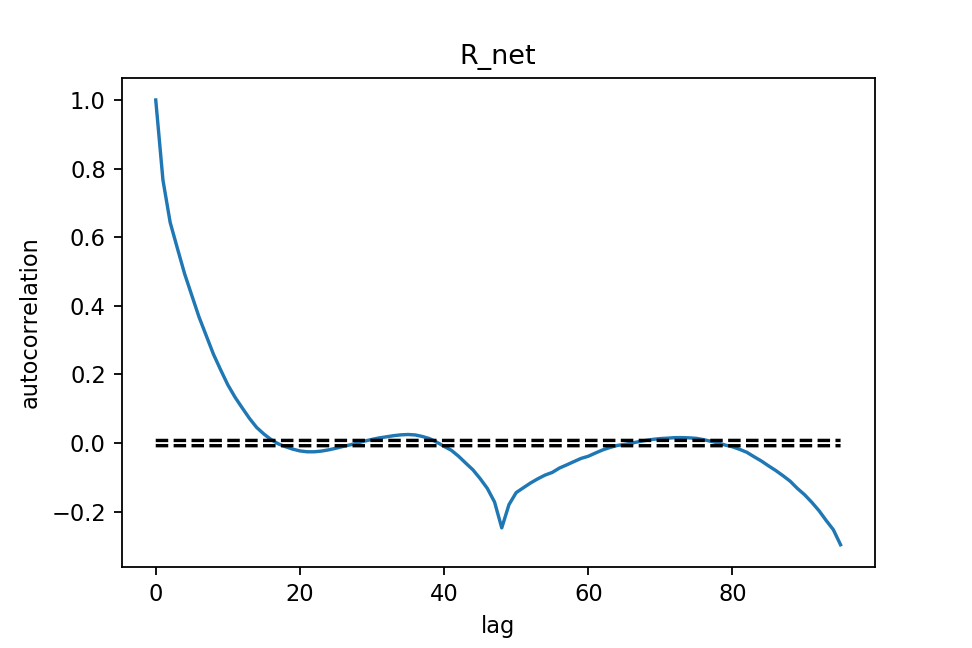

<IPython.core.display.Javascript object>


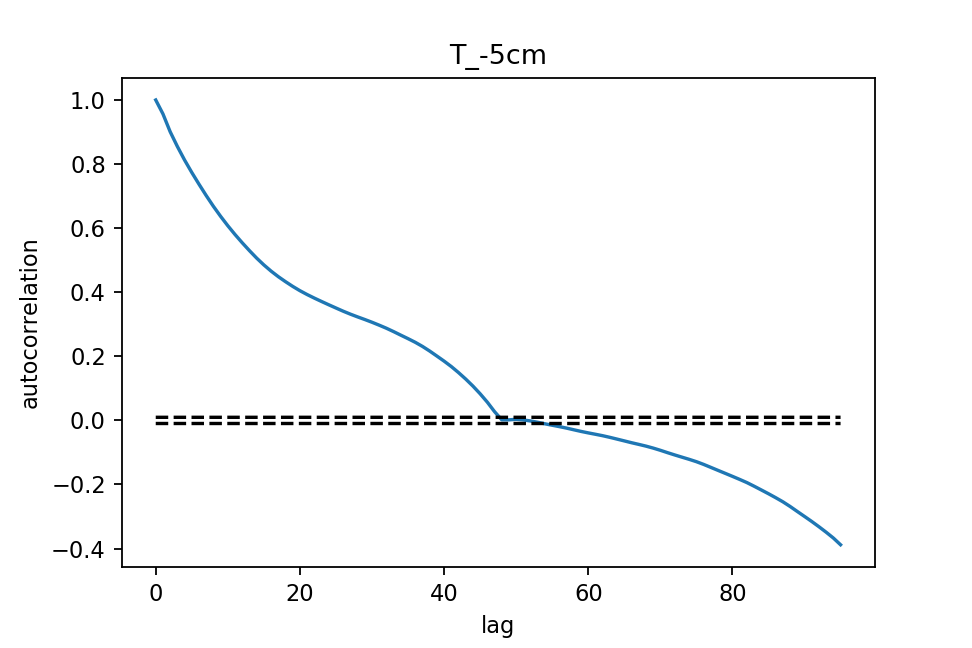

<IPython.core.display.Javascript object>


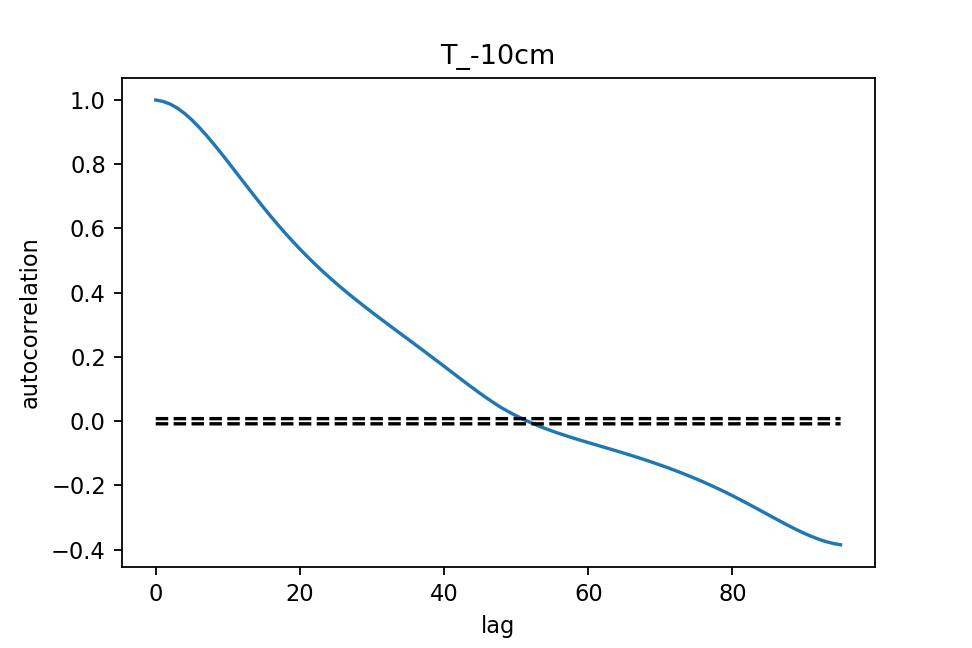

<IPython.core.display.Javascript object>


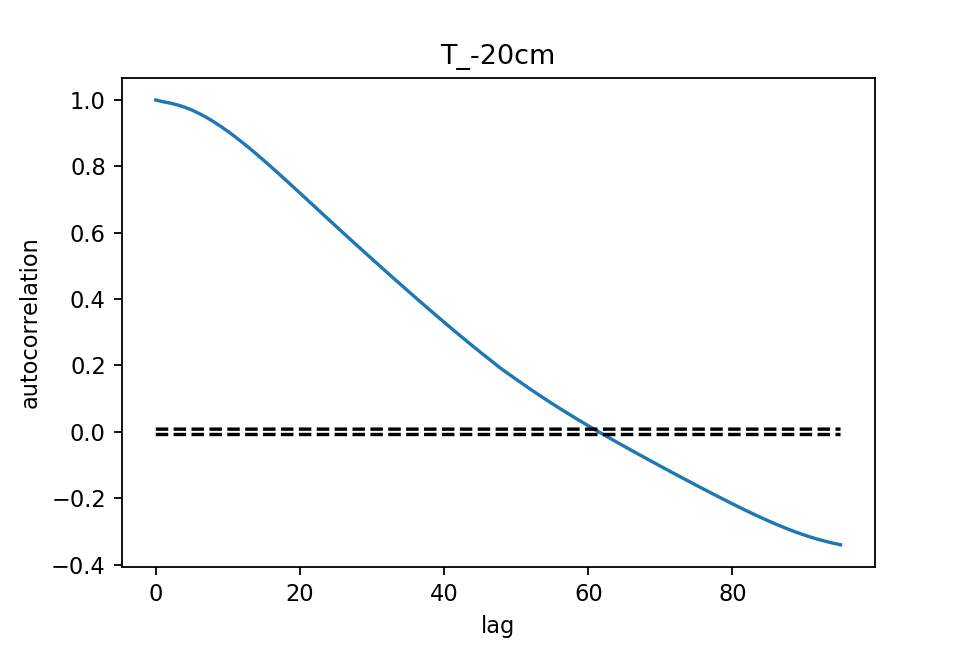

<IPython.core.display.Javascript object>


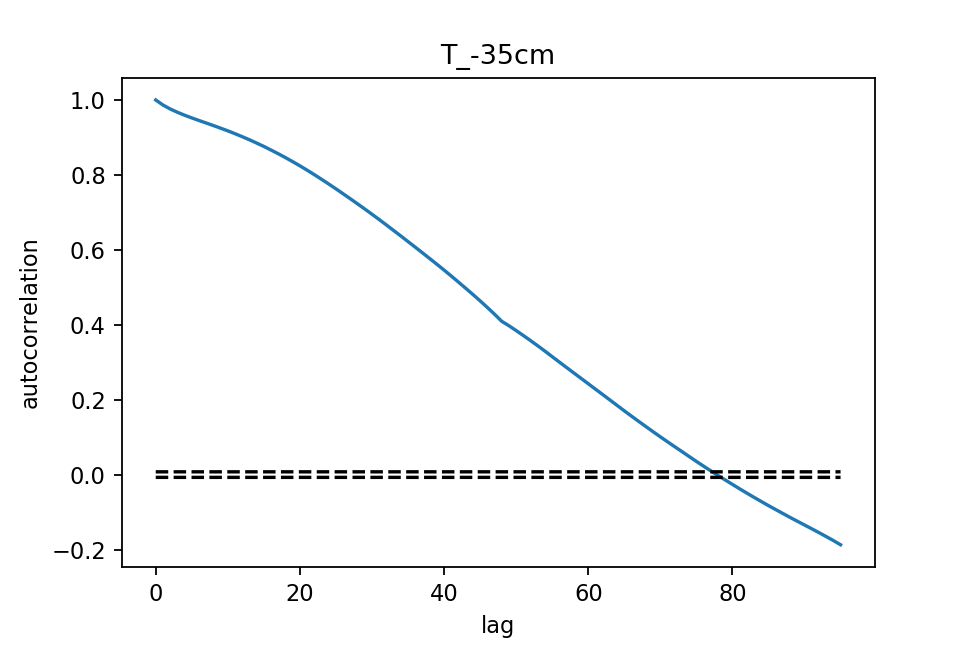

<IPython.core.display.Javascript object>


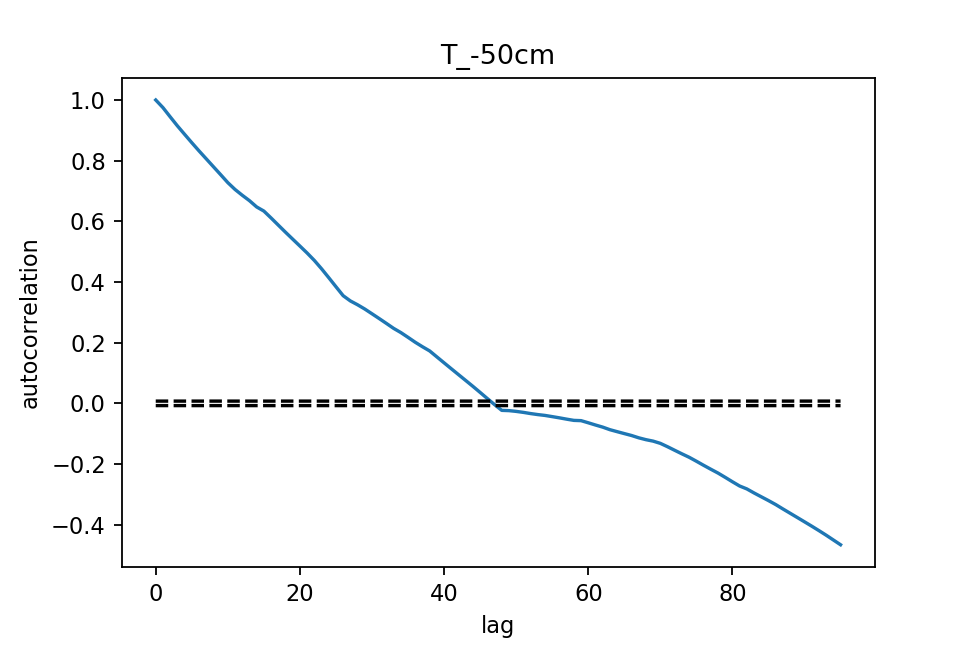

<IPython.core.display.Javascript object>


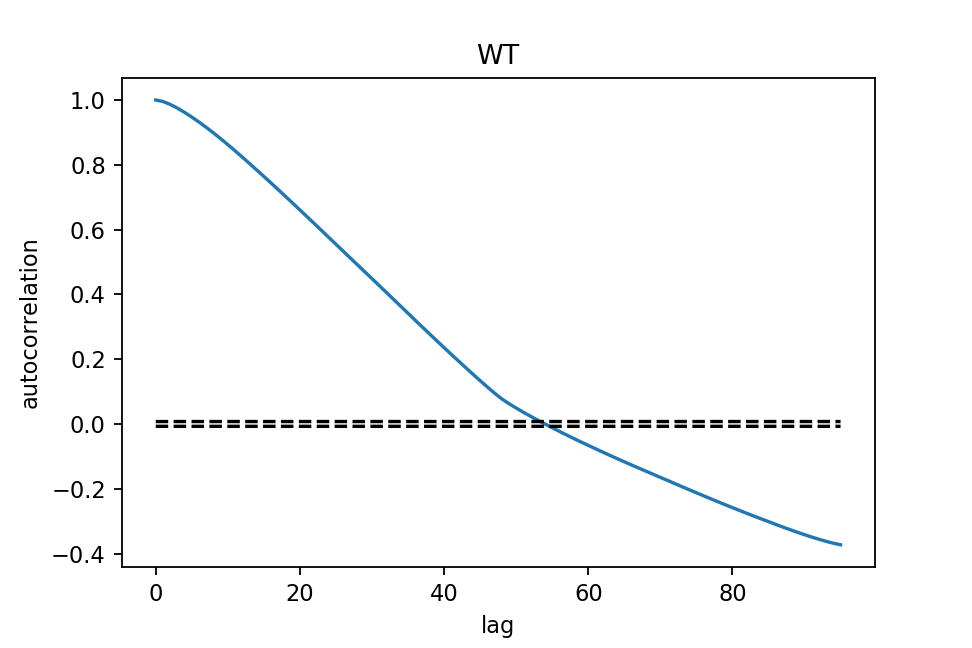

<IPython.core.display.Javascript object>


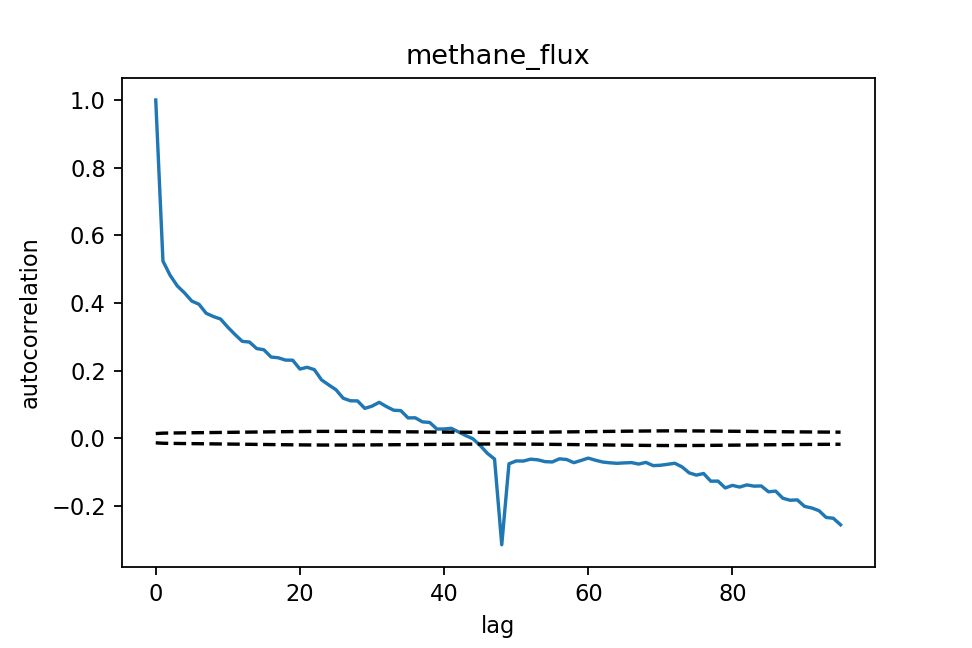

<IPython.core.display.Javascript object>


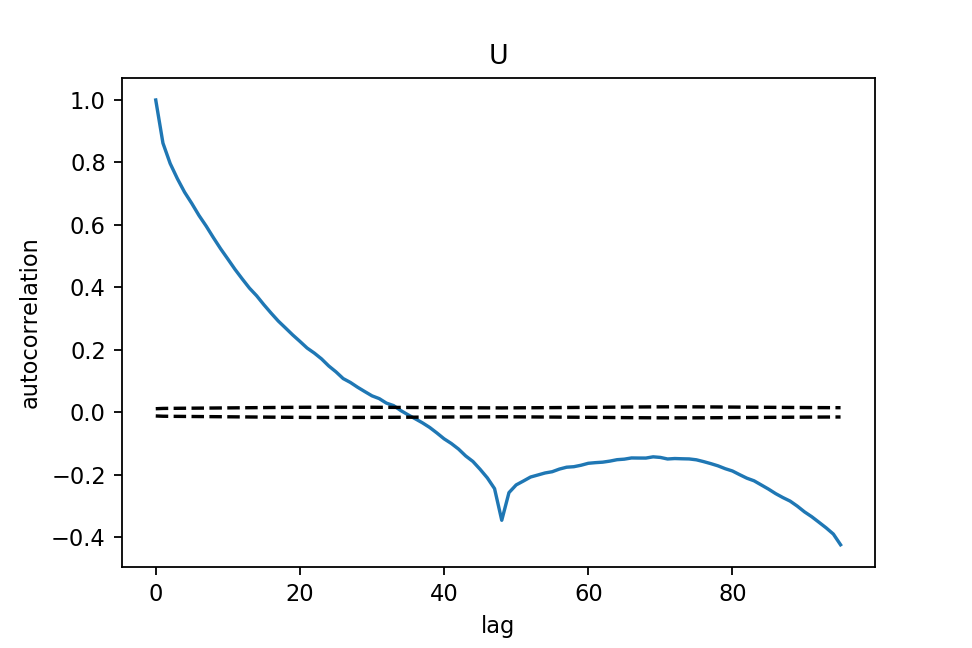

<IPython.core.display.Javascript object>


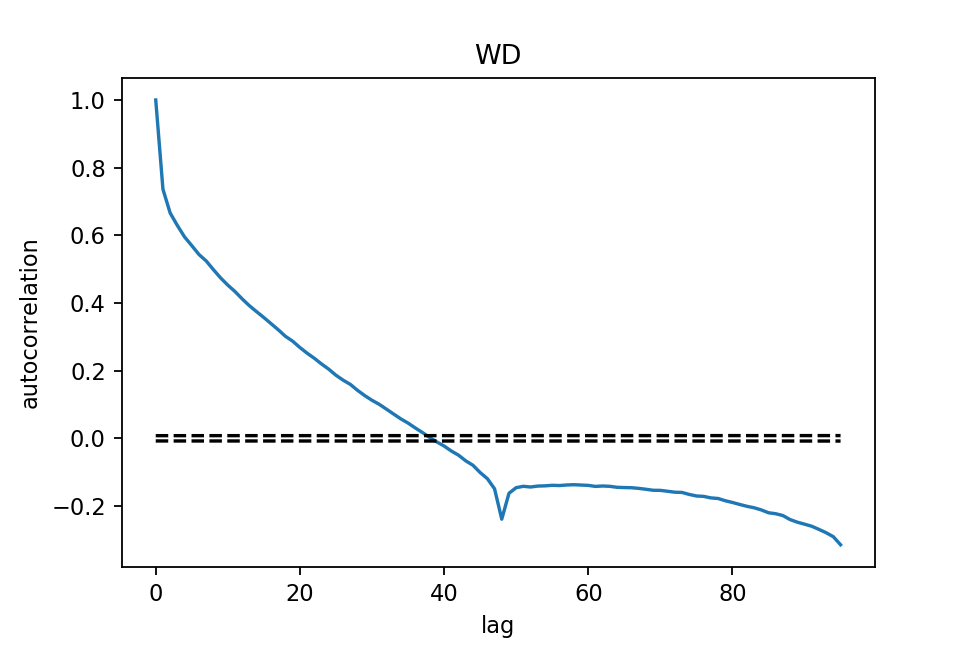

<IPython.core.display.Javascript object>


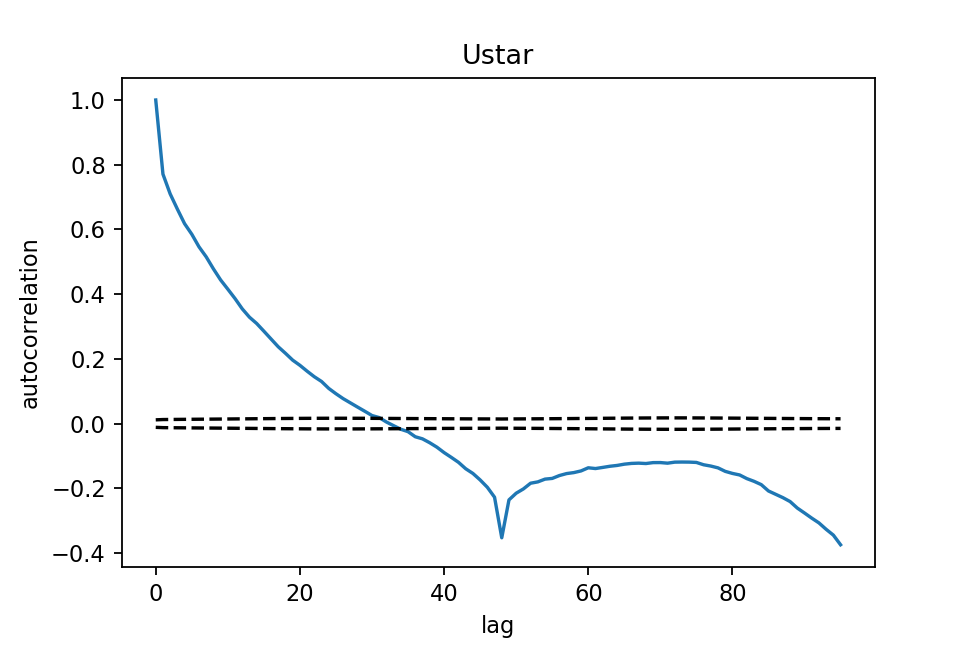

<IPython.core.display.Javascript object>


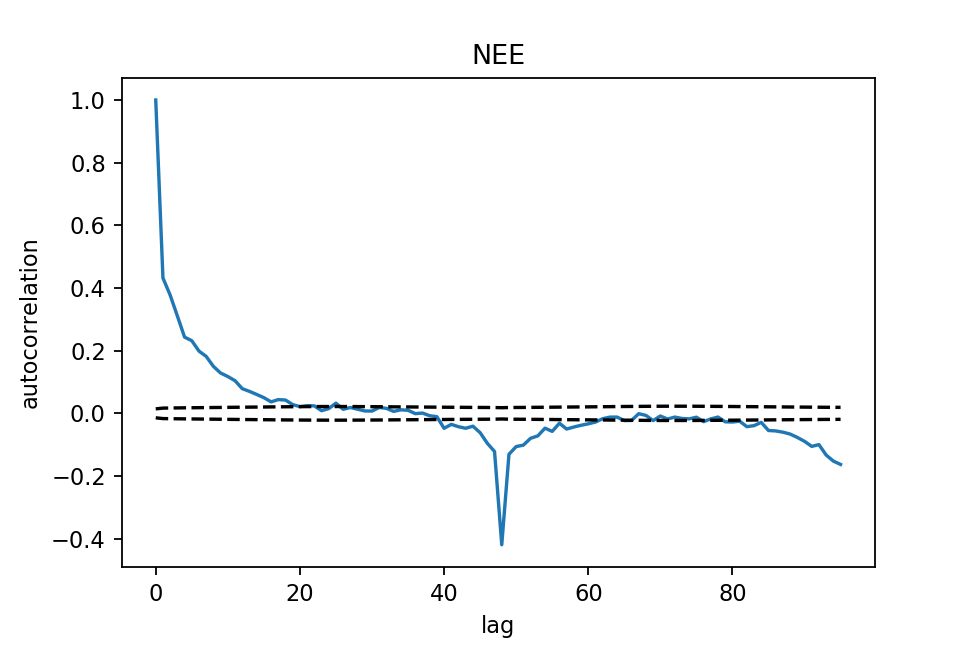

<IPython.core.display.Javascript object>


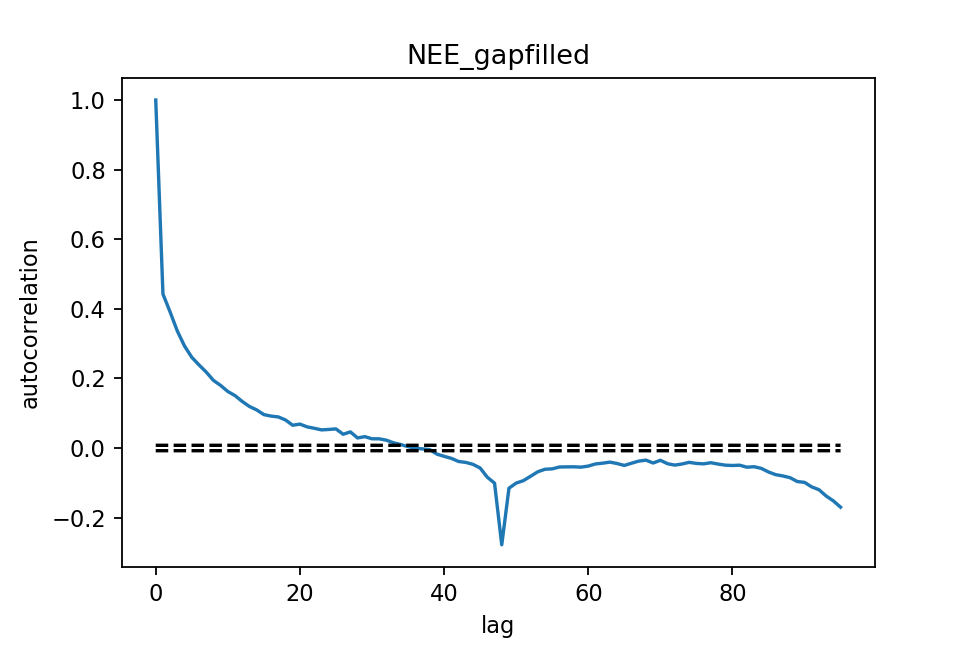

<IPython.core.display.Javascript object>


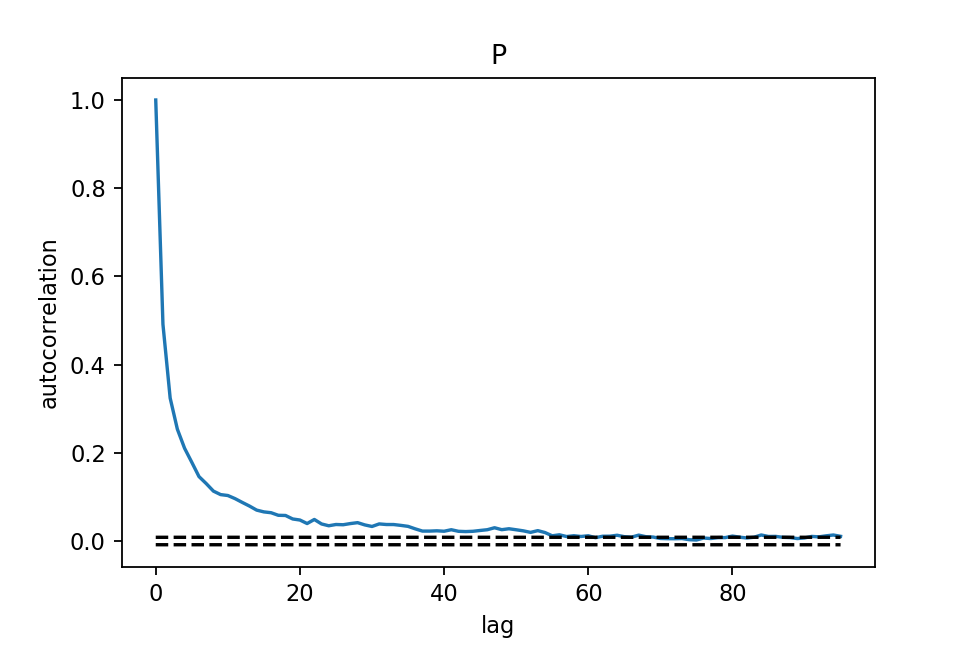

In [105]:
count = 0
for column in newData:
    (r, sig_thr) = nanacf(newData.loc[:,column].values, maxlag=96) #max lag here is 2 days
    plt.figure()
    plt.plot(r)
    plt.plot(sig_thr, 'k--')
    plt.plot(-sig_thr, 'k--')
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    plt.title(newData.columns[count])
    count = count + 1
    above_thr = r-sig_thr
    not_corr = np.where(above_thr<0)
    if np.min(np.size(not_corr))>0:
        
        per = not_corr[0][0]
    else:
        per = 999
    #print(np.size(per))
 #   if per <= 18: #Print out variables that have a period deemed acceptable for avoiding pseudoreplication (albeit subjective)
#    print(column)
#    print(per)

### Evaluate histograms

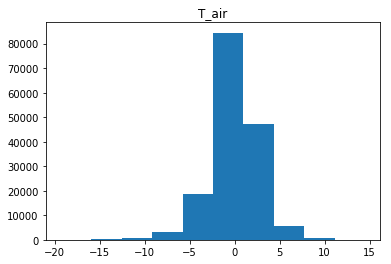

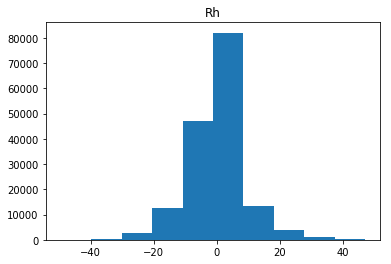

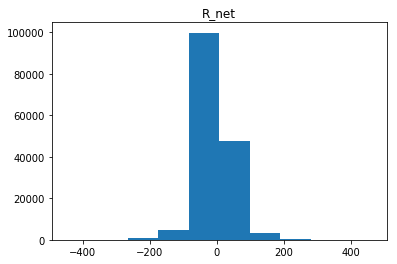

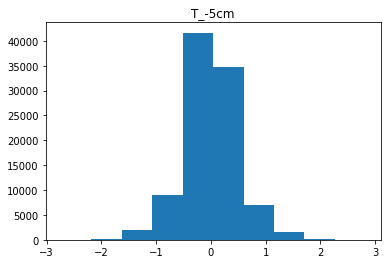

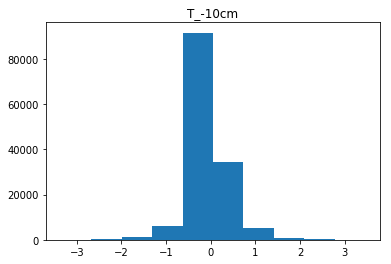

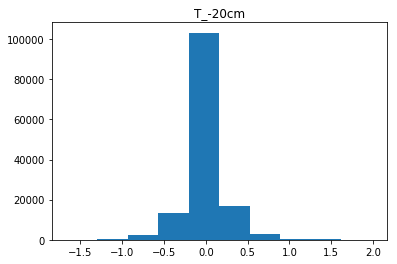

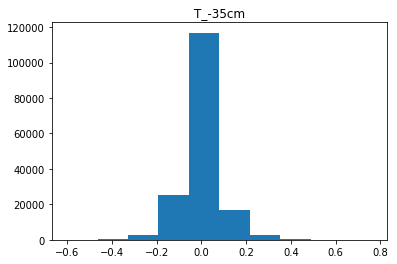

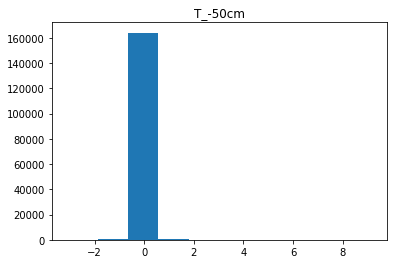

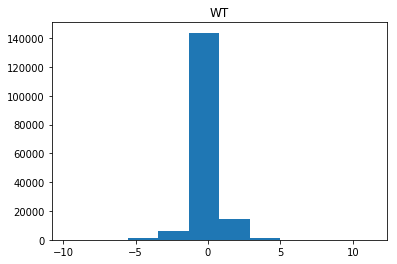

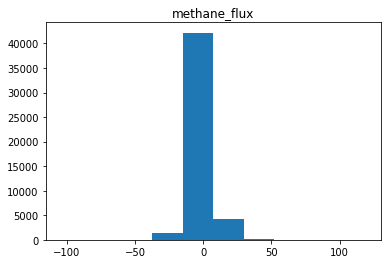

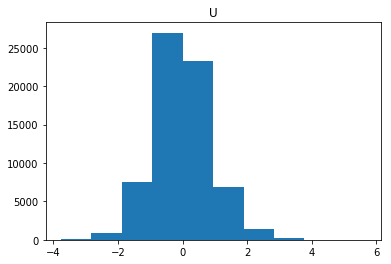

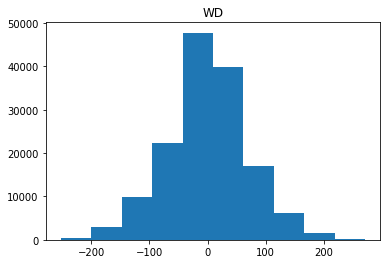

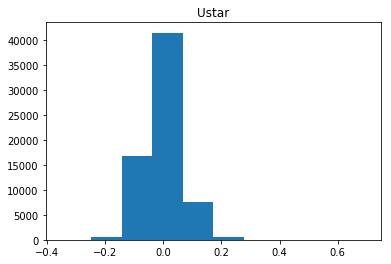

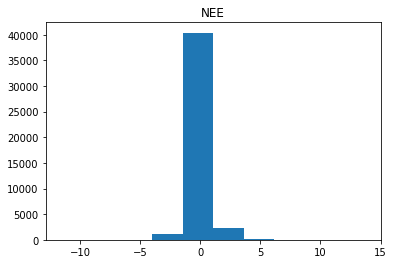

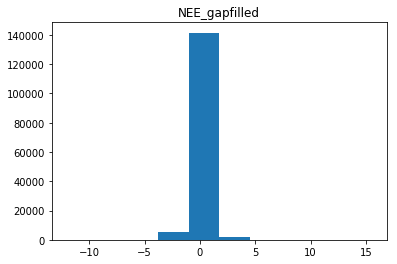

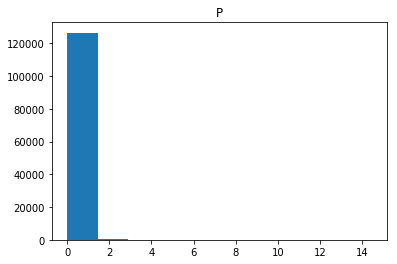

In [110]:
%matplotlib inline
count = 0
for column in newData:
    pylab.figure()
    pylab.hist((newData.loc[~np.isnan(newData[column]), column]))
    pylab.title(newData.columns[count])
    count = count + 1

##### Observation:
May want to transform data to increase entropy and make distributions more normal. Since we are only using 5 days for the moving window, many of the data are close to zero. However, there are some spikes.

## TE, Ben's periodic anomaly removal, not transformed, not resampled, t-1

In [113]:
# Adjust input for TE 
Table = copy.deepcopy(newData)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,10), 11:numVr-1, numVr]# ,10)] transformed, np.arange(15, 18)]  # np.array([2,3])
SinN = np.array([10]) 
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

['DateTime' 'methane_flux' 'T_air' 'Rh' 'R_net' 'T_-5cm' 'T_-10cm'
 'T_-20cm' 'T_-35cm' 'T_-50cm' 'WT' 'U' 'WD' 'Ustar' 'NEE' 'P']


In [114]:
#Use a maxlag of 18 hours (i.e., 36 half hours)
#importlib.reload(TEpython3)

sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer2(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=36,shift=sf)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  10 methane_flux
Lag  Sink Source
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
Source node  1 Rh :=> Sink node  10 methane_flux
Lag  Sink Source
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
12 0 1
13 0 1
14 0 1
15 0 1
16 0 1
17 0 1
18 0 1
19 0 1
20 0 1
21 0 1
22 0 1
23 0 1
24 0 1
25 0 1
26 0 1
27 0 1
28 0 1
29 0 1
30 0 1
31 0 1
32 0 1
33 0 1
34 0 1
35 0 1
Source node  2 R_net :=> Sink node  10 methane_flux
Lag  Sink Source
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
12 0 2
13 0 2
14 0 2
15 0 2
16 0 2
17 0 2
18 0 2
19 0 2
20 0 2
21 0 2
22 0 2
23 0 2
24 0 2
25 0 2
26 0 2
27 0 2
28 0 2
29 0 2
30 0 2
31 0 2
32 0 2
33 0 2
34 0 2
35 0 2
Source node  3 T_-5cm :=> S

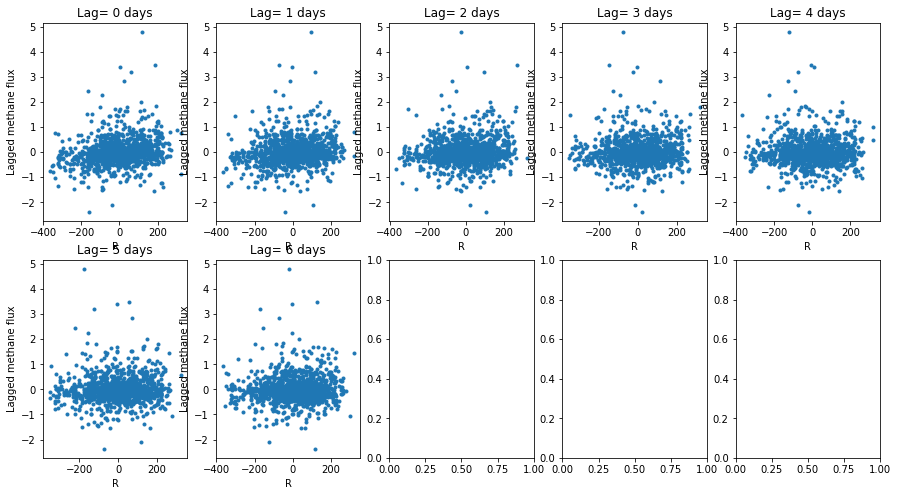

In [29]:
# Plot R vs methane flux
lag = np.arange(0, 7)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    if n==0:
        y = np.array(Table.iloc[:]['methane_flux'])
        x = np.array(Table.iloc[:]['R'])
    else:
        y = np.array(Table.iloc[n:]['methane_flux'])
        x = np.array(Table.iloc[:-n]['R'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('R')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

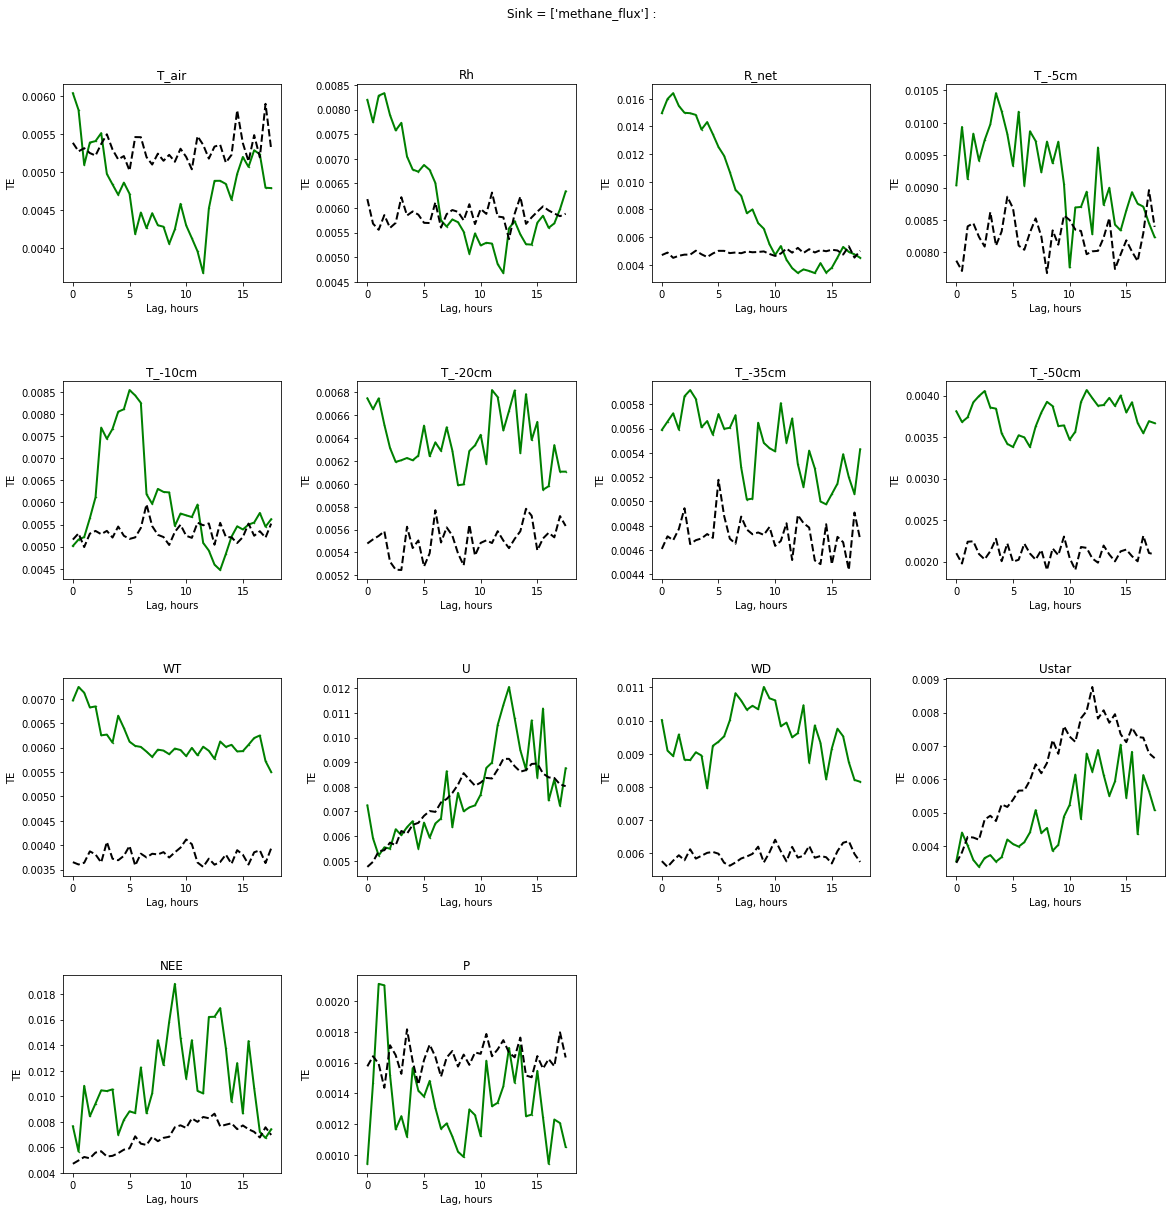

In [118]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 36

n = Tcube_store.shape[1]
plt.figure(figsize=[18,18])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
ACLabels = [] #Initialize an empty list that will contain the source variables for each row of AboveCritic
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag)/2, Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, hours')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag)/2, Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    
    ACLabels.append(LabelC[SourN[i]])
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title(ACLabels[i])
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    if np.sum(~np.isnan(AboveCritic[i,:])):
        LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

C:\Users\Laurel Larsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


Text(0.5,0,'TE at Lag (days)')

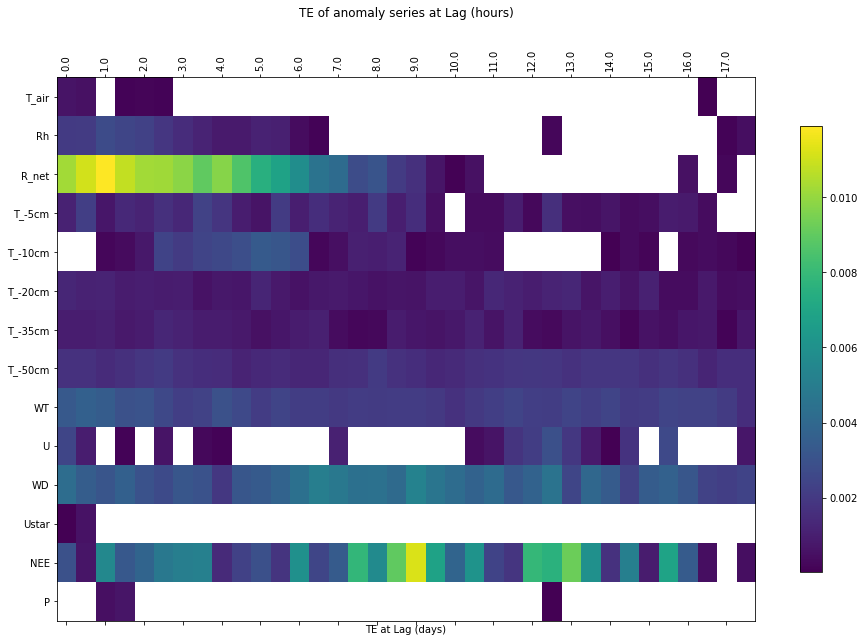

In [124]:
# Step 2/3
# Comparison accross variables
# Assign values less than critical to Nan
indNan = np.argwhere(AboveCritic<0)
AboveCritic[indNan[:,0],indNan[:,1]] = np.nan

names = LabelC[SourN]
minV = np.nanmin(AboveCritic)
maxV = np.nanmax(AboveCritic)

fig = plt.figure(1,figsize = (20,10)) 
ax = fig.add_subplot(111)
cax = ax.matshow(AboveCritic, vmin=minV, vmax=maxV,cmap='viridis', aspect=2) #cmap='ivaris'
ticksY = np.arange(0,names.shape[0],1)
ticksX = np.arange(0,maxLag,2)
ax.set_xticks(ticksX)
ax.set_yticks(ticksY)
ax.set_xticklabels(ticksX/2)
ax.set_yticklabels(names)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=90)
plt.colorbar(cax,fraction=0.02, pad=0.04)
plt.title('TE of anomaly series at Lag (hours)',y=1.1)
plt.xlabel('TE at Lag (days)')

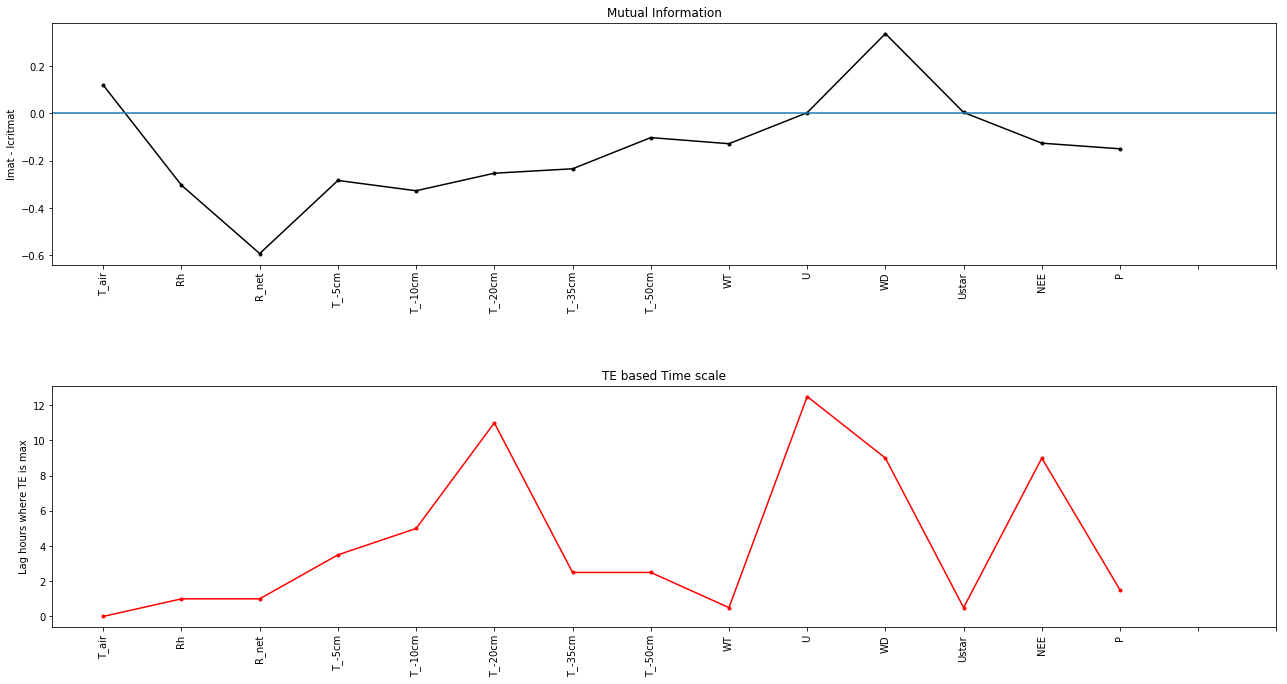

In [127]:
# Step 3/3
# Plotting Critical timescale and Mutual information. Mutual information in this excercise does not include lag. 
plt.figure(figsize=[20,10])
plt.subplot(2,1,1)
plt.plot((Imat-Icritmat).T,'k.-')
plt.ylabel('Imat - Icritmat')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('Mutual Information')
plt.axhline()
# plt.xticks([]) # hides the tick marks

plt.subplot(2,1,2)
plt.plot((LagTime/2).T,'r.-')
plt.ylabel('Lag hours where TE is max')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('TE based Time scale')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

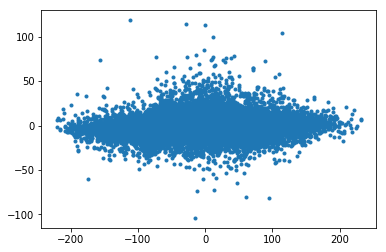

In [128]:
plt.plot(newData.WD, newData.methane_flux, '.')

Methane flux is potentially highest when wind direction is "normal." When odd systems are coming in, something shuts off spikes?

## TE, nontransformed, t-lag, Ruddell anomaly, no resampling


In [130]:
importlib.reload(TEpython3)


Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=36)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  10 methane_flux
Lag  Sink Source
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
Source node  1 Rh :=> Sink node  10 methane_flux
Lag  Sink Source
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
12 0 1
13 0 1
14 0 1
15 0 1
16 0 1
17 0 1
18 0 1
19 0 1
20 0 1
21 0 1
22 0 1
23 0 1
24 0 1
25 0 1
26 0 1
27 0 1
28 0 1
29 0 1
30 0 1
31 0 1
32 0 1
33 0 1
34 0 1
35 0 1
Source node  2 R_net :=> Sink node  10 methane_flux
Lag  Sink Source
0 0 2
1 0 2
2 0 2
3 0 2
4 0 2
5 0 2
6 0 2
7 0 2
8 0 2
9 0 2
10 0 2
11 0 2
12 0 2
13 0 2
14 0 2
15 0 2
16 0 2
17 0 2
18 0 2
19 0 2
20 0 2
21 0 2
22 0 2
23 0 2
24 0 2
25 0 2
26 0 2
27 0 2
28 0 2
29 0 2
30 0 2
31 0 2
32 0 2
33 0 2
34 0 2
35 0 2
Source node  3 T_-5cm :=> S

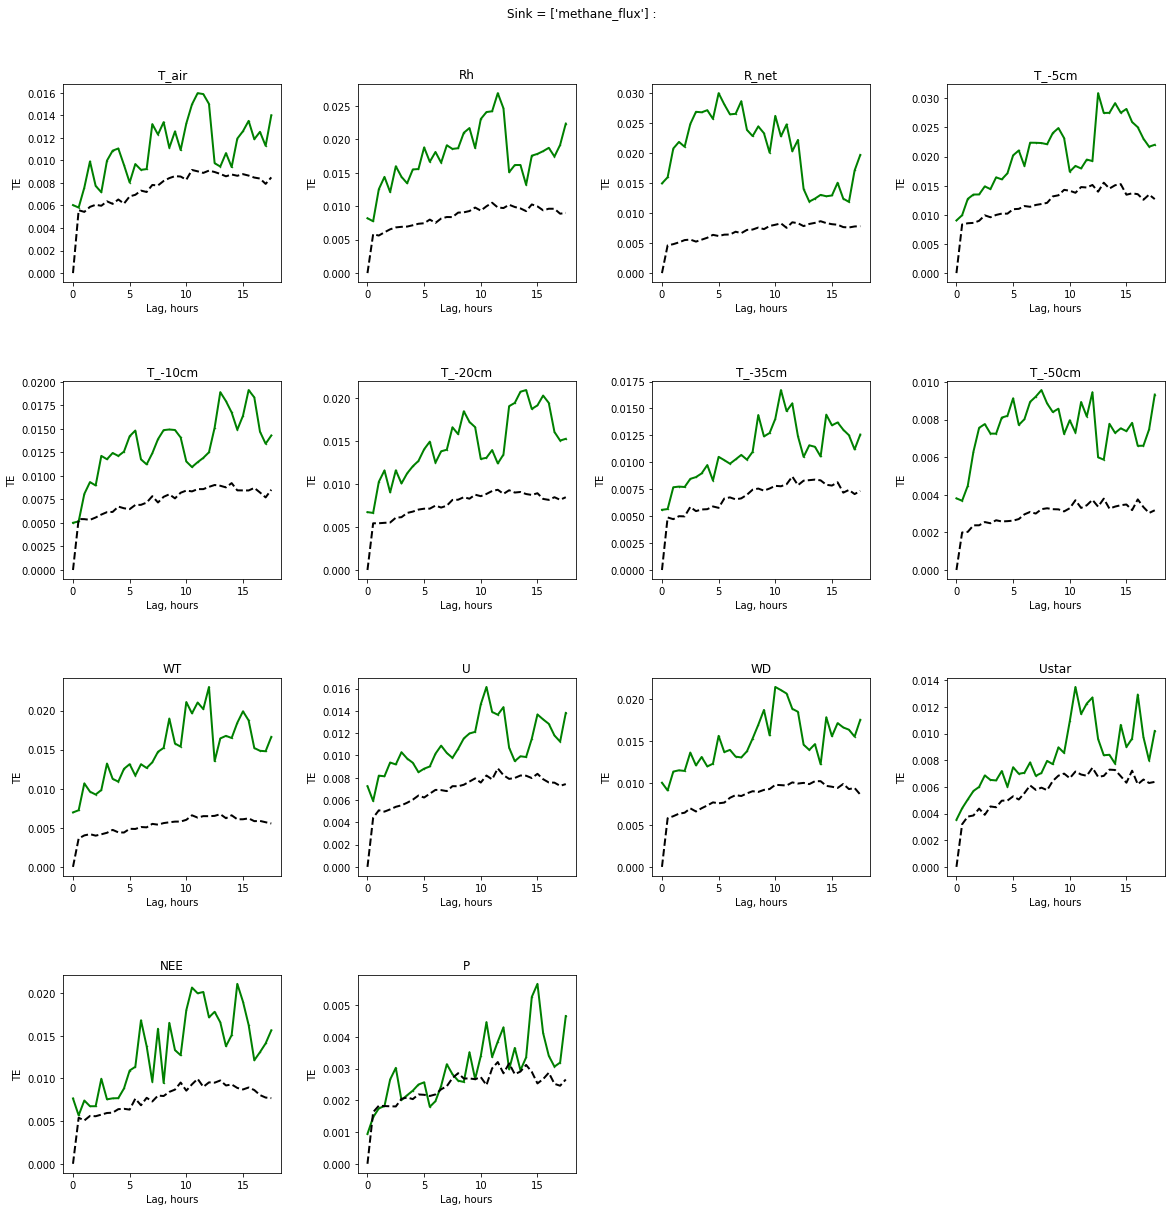

In [132]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 36

n = Tcube_store.shape[1]
plt.figure(figsize=[18,18])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
ACLabels = [] #Initialize an empty list that will contain the source variables for each row of AboveCritic
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag)/2, Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, hours')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag)/2, Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    
    ACLabels.append(LabelC[SourN[i]])
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title(ACLabels[i])
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

Text(0.5,0,'TE at Lag (hours)')

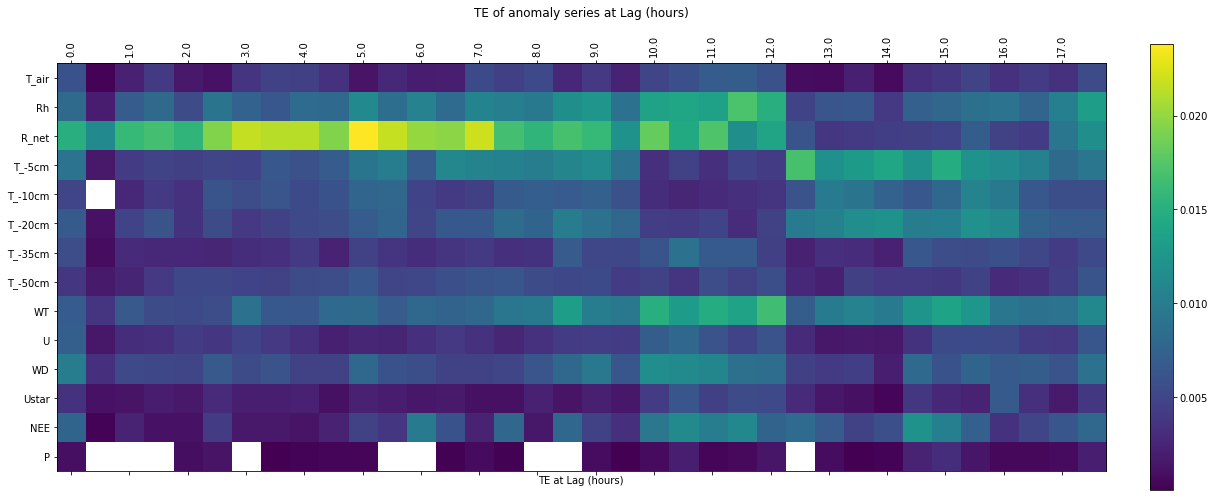

In [133]:
# Step 2/3
# Comparison accross variables
# Assign values less than critical to Nan
indNan = np.argwhere(AboveCritic<0)
AboveCritic[indNan[:,0],indNan[:,1]] = np.nan

names = LabelC[SourN]
minV = np.nanmin(AboveCritic)
maxV = np.nanmax(AboveCritic)

fig = plt.figure(1,figsize = (20,15)) 
ax = fig.add_subplot(111)
cax = ax.matshow(AboveCritic, vmin=minV, vmax=maxV,cmap='viridis', aspect=1) #cmap='ivaris'
ticksY = np.arange(0,names.shape[0],1)
ticksX = np.arange(0,maxLag,2)
ax.set_xticks(ticksX)
ax.set_yticks(ticksY)
ax.set_xticklabels(ticksX/2)
ax.set_yticklabels(names)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=90)
plt.colorbar(cax,fraction=0.02, pad=0.04)
plt.title('TE of anomaly series at Lag (hours)',y=1.1)
plt.xlabel('TE at Lag (hours)')

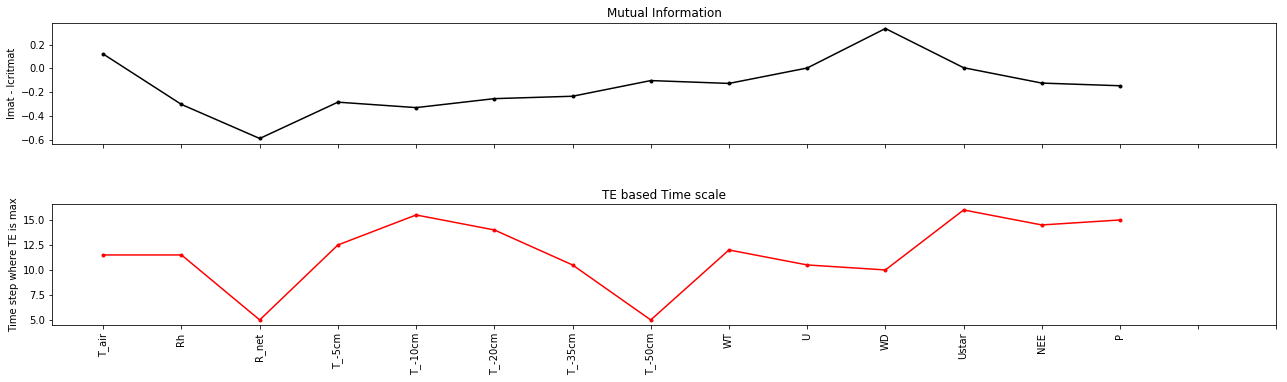

In [135]:
# Step 3/3
# Plotting Critical timescale and Mutual information. Mutual information in this excercise does not include lag. 
plt.figure(figsize=[20,5])
plt.subplot(2,1,1)
plt.plot((Imat-Icritmat).T,'k.-')
plt.ylabel('Imat - Icritmat')
plt.xticks(np.arange(numVr)," ")
plt.title('Mutual Information')
# plt.xticks([]) # hides the tick marks

plt.subplot(2,1,2)
plt.plot((LagTime).T/2,'r.-')
plt.ylabel('Time step where TE is max')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('TE based Time scale')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

## TE, nontransformed, t-per, Ruddell anomaly, resampling


In [ ]:
#Use a maxlag of 18 hours (i.e., 36 half hours)
importlib.reload(TEpython4)

sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython4.RunNewTE2VarsSer2(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, minSamples=50, sigLevel=0.01, maxLag=36,shift=sf, do_not_resample = ['P'])

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  10 methane_flux
Lag  Sink Source
36
0 0 0 582
1 0 0 572
2 0 0 599
3 0 0 600
4 0 0 600
5 0 0 599
6 0 0 599
7 0 0 596
8 0 0 597
9 0 0 597
10 0 0 596
11 0 0 595
12 0 0 574
13 0 0 555
14 0 0 594
15 0 0 599
16 0 0 598
17 0 0 597
18 0 0 600
19 0 0 599
20 0 0 599
21 0 0 600
22 0 0 600
23 0 0 599
24 0 0 549
25 0 0 536
26 0 0 597
